In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import pickle
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import gc
import time
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
import bert


Populating the interactive namespace from numpy and matplotlib


C:\Users\dhirajsrivastava\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
train_images = 'train2014/train2014'
val_images = 'val2014/val2014'

In [3]:
data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')

In [4]:
data.dropna(inplace = True)
val_data.dropna(inplace = True)

In [5]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_text(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
        if i==0:
            new_text = contractions.get(word,word)
        else:
            new_text = new_text + " " + contractions.get(word,word)
        i += 1
    return new_text.replace("'s", '')

In [6]:
data['multiple_choice_answer'] = data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))
val_data['multiple_choice_answer'] = val_data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))

In [7]:
# X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)
X_train = data
X_val = val_data
len(X_train), len(X_val)

(443749, 214349)

In [8]:
img_width = 448
img_height = 448

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [9]:
with open('train_image_dict.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)

In [10]:
with open('val_image_dict.pickle', 'rb') as handle:
    val_image_dict = pickle.load(handle)

In [11]:
# Get keys
oldkeys = list(all_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Train', 'train2014/train2014') for s in oldkeys]
# Get values
vals = list(all_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
all_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [12]:
# Get keys
oldkeys = list(val_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Val', 'val2014/val2014') for s in oldkeys]
# Get values
vals = list(val_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
val_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [13]:
all_image_dict.update(val_image_dict)

In [14]:
train_images = 'train2014/train2014'
val_images = 'val2014/val2014'

In [15]:
len(X_train), len(X_val)

(443749, 214349)

In [16]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

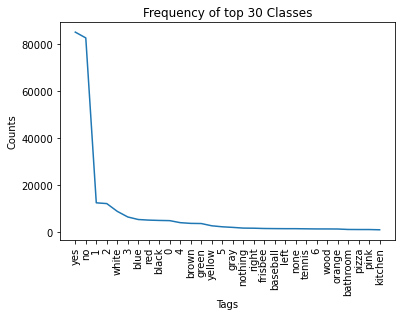

In [17]:
sort_class_frequency = sorted(list(class_frequency.items()), key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

In [18]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)

In [19]:
# take the top 1000 classes
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

# removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [20]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (388247, 1000)
Shape of Answer Vectors in Validation Data:  (214349, 1000)


In [21]:
def preprocess_question(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
        new_text = new_text + " " + contractions.get(word, word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [22]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_question(x))

<ipython-input-22-c9f73ee18296>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))


In [23]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)
val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])

print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)
print("Shape of Question Vectors in Validation Data: ", question_vector_val.shape)

Number of words in tokenizer: 12449
Shape of Question Vectors in Train Data:  (388247, 24)
Shape of Question Vectors in Validation Data:  (214349, 24)


In [24]:
image_paths_train = X_train['image_id'].apply(lambda x:  train_images + '/COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  val_images + '/COCO_val2014_' + '%012d.jpg' % (x)).values


In [25]:
def get_imageTensor(img, ques):
    #path = img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace('.jpg',"") +'.npy'
    #img_tensor = np.load(path)
    img_tensor = all_image_dict[img.decode('utf-8')]
    img_tensor = tf.squeeze(img_tensor)
#     print('img : ' + str(img_tensor.shape))
    return img_tensor, ques

def createDataset(image_paths, question_vector, answer_vector):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32)))
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vector.astype(np.float32)))
    
    # using map to load the numpy files in parallel
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(get_imageTensor, [img, ques], [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # shuffling and batching
    #dataset_input = dataset_input.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset_input = dataset_input.batch(BATCH_SIZE)
    dataset_output = dataset_output.batch(BATCH_SIZE)#.repeat()
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [26]:
question_vector_train.shape, image_paths_train.shape, answer_vector_train.shape

((388247, 24), (388247,), (388247, 1000))

In [27]:
question_vector_val.shape, image_paths_val.shape, answer_vector_val.shape

((214349, 24), (214349,), (214349, 1000))

In [28]:
dataset_train = createDataset(image_paths_train, question_vector_train, answer_vector_train)
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val)

In [29]:
dataset_train

<PrefetchDataset shapes: ((<unknown>, <unknown>), (None, 1000)), types: ((tf.float32, tf.float32), tf.float32)>

In [30]:
list(all_image_dict.values())[0].shape

(1, 7, 7, 512)

In [31]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [32]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

In [33]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "/optimum.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    #print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

In [34]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [36]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("coattention_model_1/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_14:0", shape=(None, 1, 512), dtype=float32)
Epoch 1/20
(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("model_1/coattention_model_1/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_1/coattention_model_1/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_1/coattention_model_1/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_1/coattention_model_1/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_1/coattention_model_1/MatMul_13:0", shape=(None, 1, 512), dtype=f

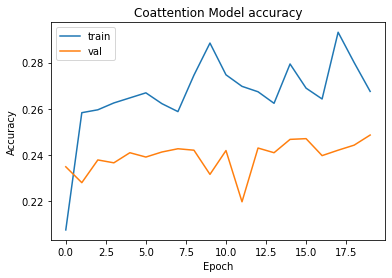

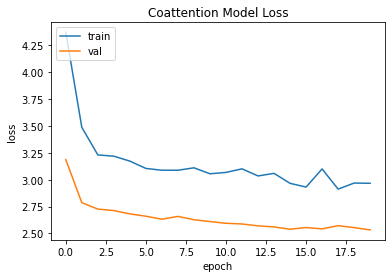

In [37]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Coattention Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Coattention Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
model.save('Models/coattention.h5')

                                                                                   SGD

In [41]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.SGD(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [42]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_14:0", shape=(None, 1, 512), dtype=float32)
Epoch 1/20
(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("model/coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattentio

In [43]:
model.save('Models/coattention_SGD.h5')

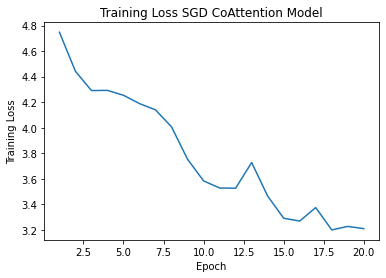

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
ypoints = [4.7477,4.4418,4.2909,4.2922,4.2538,4.1888,4.1395,4.0061,3.7524,3.5831,3.5273,3.5259,3.7270,3.4643,3.2905,3.2688,3.3741,3.1991,3.2266,3.2090]
xpoints = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
new_list = range(math.floor(min(xpoints)), math.ceil(max(xpoints))+1)
plt.title("Training Loss SGD CoAttention Model")
plt.xlabel("Epoch")
plt.ylabel("Training Loss");
plt.plot(new_list, ypoints)
plt.show()

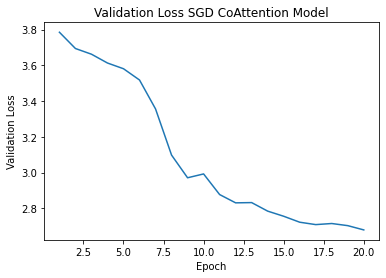

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
ypoints = [3.7852,3.6942,3.6624,3.6131,3.5811,3.5181,3.3564,3.0983,2.9713,2.9928,2.8775,2.8311,2.8325,2.7848,2.7561,2.7228,2.7094,2.7155,2.7036,2.6797]
xpoints = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
new_list = range(math.floor(min(xpoints)), math.ceil(max(xpoints))+1)
plt.title("Validation Loss SGD CoAttention Model")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss");
plt.plot(new_list, ypoints)
plt.show()

                                     LSTM units 256, hidden size 256

In [44]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 256
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 256, return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        #print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        #print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        #print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [45]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

In [46]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "/optimum.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    #print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

In [49]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [50]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

Epoch 1/20
100/100 [==============================] - 221s 2s/step - loss: 4.4613 - accuracy: 0.2103 - val_loss: 3.6911 - val_accuracy: 0.1881
Epoch 2/20
100/100 [==============================] - 226s 2s/step - loss: 3.8317 - accuracy: 0.2400 - val_loss: 3.1435 - val_accuracy: 0.2252
Epoch 3/20
100/100 [==============================] - 221s 2s/step - loss: 3.5039 - accuracy: 0.2547 - val_loss: 2.8165 - val_accuracy: 0.2216
Epoch 4/20
100/100 [==============================] - 219s 2s/step - loss: 3.3604 - accuracy: 0.2711 - val_loss: 2.7485 - val_accuracy: 0.2286
Epoch 5/20
100/100 [==============================] - 221s 2s/step - loss: 3.2512 - accuracy: 0.2608 - val_loss: 2.7051 - val_accuracy: 0.2389
Epoch 6/20
100/100 [==============================] - 221s 2s/step - loss: 3.2198 - accuracy: 0.2644 - val_loss: 2.7690 - val_accuracy: 0.2359
Epoch 7/20
100/100 [==============================] - 219s 2s/step - loss: 3.1970 - accuracy: 0.2616 - val_loss: 2.6798 - val_accuracy: 0.2427

In [51]:
model.save('Models/coattention_lstm 256.h5')

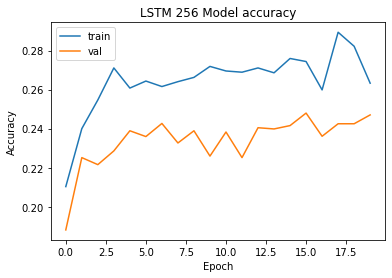

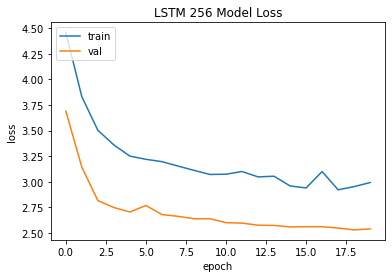

In [57]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM 256 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM 256 Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.5
        self.num_embeddings = len(ques_vocab)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512, return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        #print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        #print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        #print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [59]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

In [60]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "/optimum.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    #print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

In [61]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [62]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

Epoch 1/20
100/100 [==============================] - 406s 4s/step - loss: 4.5150 - accuracy: 0.1991 - val_loss: 4.2601 - val_accuracy: 0.1881
Epoch 2/20
100/100 [==============================] - 374s 4s/step - loss: 4.1656 - accuracy: 0.2192 - val_loss: 3.3560 - val_accuracy: 0.2747
Epoch 3/20
100/100 [==============================] - 377s 4s/step - loss: 3.6716 - accuracy: 0.2383 - val_loss: 3.0593 - val_accuracy: 0.2095
Epoch 4/20
100/100 [==============================] - 377s 4s/step - loss: 3.5880 - accuracy: 0.2459 - val_loss: 2.9150 - val_accuracy: 0.2147
Epoch 5/20
100/100 [==============================] - 381s 4s/step - loss: 3.4152 - accuracy: 0.2531 - val_loss: 2.8382 - val_accuracy: 0.2389
Epoch 6/20
100/100 [==============================] - 376s 4s/step - loss: 3.2719 - accuracy: 0.2617 - val_loss: 2.8132 - val_accuracy: 0.2375
Epoch 7/20
100/100 [==============================] - 379s 4s/step - loss: 3.2895 - accuracy: 0.2528 - val_loss: 2.7640 - val_accuracy: 0.2308

In [63]:
model.save('Models/coattention dropout 0.5.h5')

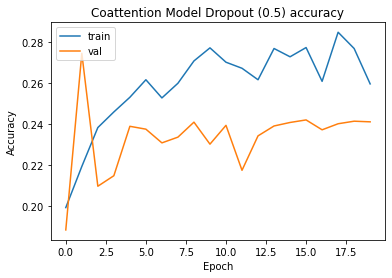

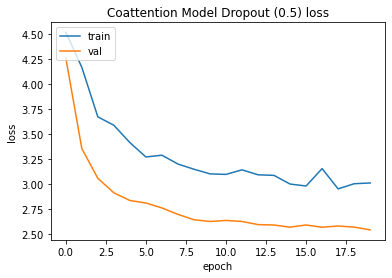

In [64]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Coattention Model Dropout (0.5) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Coattention Model Dropout (0.5) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()